# Segmentation


# Importing


In [1]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

# Data Collecting

In [4]:

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'
train_ids = next(os.walk(TRAIN_PATH))[1]  # Fetches IDs of training data directories
test_ids = next(os.walk(TEST_PATH))[1]   # Fetches IDs of test data directories

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)  # Initialize array to store resized training images
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)  # Initialize array to store resized training masks
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)  # Initialize array to store resized test images

/var/folders/vr/ksk4m_bs4dn9qyn3wpc8nf080000gn/T/ipykernel_16683/3767802296.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [ ]:

def DataEdit(TRAIN_PATH=TRAIN_PATH, TEST_PATH=TEST_PATH, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS):
    # Load and resize train images and masks
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]  # Read and extract training image
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  # Resize the image
        X_train[n] = img  # Fill the training images array with the resized image
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)  # Initialize mask array for the image
        for mask_file in next(os.walk(path + '/masks/'))[2]:  # Loop through mask files for the image
            mask_ = imread(path + '/masks/' + mask_file)  # Read mask file
            mask_ = np.expand_dims(
                resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),
                axis=-1
            )  # Resize the mask
            mask = np.maximum(mask, mask_)  # Combine masks (if there are multiple)

        Y_train[n] = mask  # Store the combined mask in the Y_train array

    # Load and resize test images
    sizes_test = []  # Initialize list to store sizes of test images
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]  # Read and extract test image
        sizes_test.append([img.shape[0], img.shape[1]])  # Store the size of the test image
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  # Resize the test image
        X_test[n] = img  # Fill the test images array with the resized image

    return X_train, Y_train, X_test  # Return the resized training and test images/masks


# Coding Path

In [5]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

def U_Net(IMG_HEIGHT = IMG_HEIGHT, IMG_WIDTH = IMG_WIDTH, IMG_CHANNELS= IMG_CHANNELS, input = inputs):

    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalize input images

    # Contracting path (Encoder)

    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path (Decoder)

    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    return outputs
 
model = tf.keras.Model(inputs=[inputs], outputs= U_Net(input = inputs))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary() # Display model summary


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [6]:
DataEdit()
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)
# ModelCheckpoint callback: Saves the model after each epoch if 'val_loss' has improved

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    # EarlyStopping callback: Stops training if 'val_loss' doesn't improve for 2 consecutive epochs
    
    tf.keras.callbacks.TensorBoard(log_dir='logs')
    # TensorBoard callback: Sets up logging for visualization in TensorBoard
]

# Fitting the model
results = model.fit(
    X_train, Y_train,  # Training data: X_train contains input images, Y_train contains corresponding masks
    validation_split=0.1,  # 10% of training data used for validation during training
    batch_size=16,  # Training batch size
    epochs=25,  # Number of training epochs
    callbacks=callbacks  # Using defined callbacks during training
)


  0%|          | 0/670 [00:00<?, ?it/s]/var/folders/vr/ksk4m_bs4dn9qyn3wpc8nf080000gn/T/ipykernel_16683/3767802296.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████| 65/65 [00:00<00:00, 81.43it/s]
2023-12-29 13:35:33.713344: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/25
38/38 [==============================] - 20s 497ms/step - loss: 0.6179 - accuracy: 0.7209 - val_loss: 0.3881 - val_accuracy: 0.8093
Epoch 2/25
38/38 [==============================] - 20s 518ms/step - loss: 0.3202 - accuracy: 0.8366 - val_loss: 0.2121 - val_accuracy: 0.9111
Epoch 3/25
38/38 [==============================] - 20s 513ms/step - loss: 0.1933 - accuracy: 0.9264 - val_loss: 0.1500 - val_accuracy: 0.9417
Epoch 4/25
38/38 [==============================] - 20s 522ms/step - loss: 0.1410 - accuracy: 0.9447 - val_loss: 0.1416 - val_accuracy: 0.9434
Epoch 5/25
38/38 [==============================] - 20s 514ms/step - loss: 0.1380 - accuracy: 0.9458 - val_loss: 0.1124 - val_accuracy: 0.9576
Epoch 6/25
38/38 [==============================] - 20s 517ms/step - loss: 0.1210 - accuracy: 0.9524 - val_loss: 0.1062 - val_accuracy: 0.9590
Epoch 7/25
38/38 [==============================] - 21s 558ms/step - loss: 0.1166 - accuracy: 0.9552 - val_loss: 0.1016 - val_accuracy: 0.9619

In [7]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 143ms/step


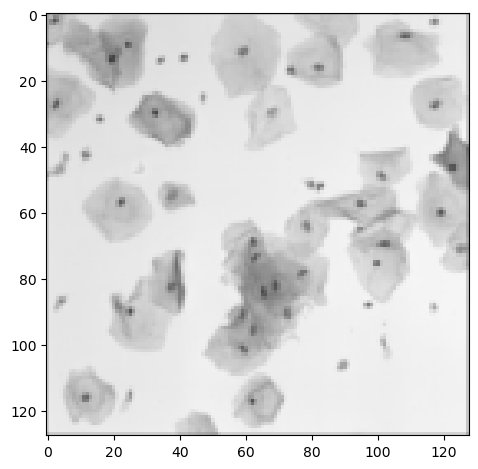

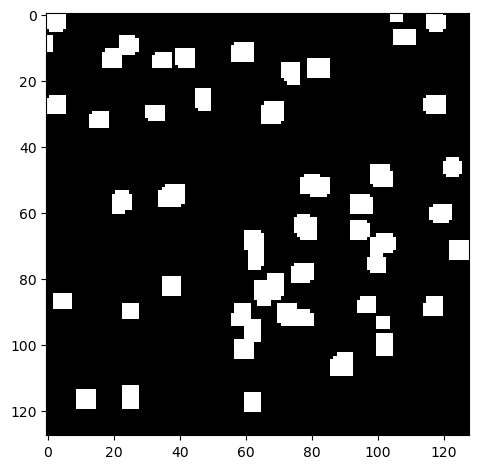

/Users/vahanarubjanyan/anaconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


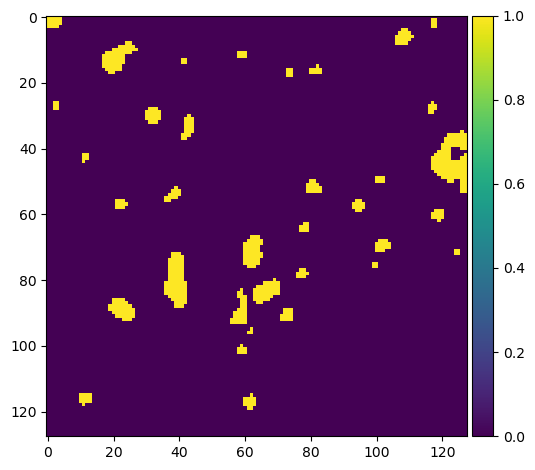

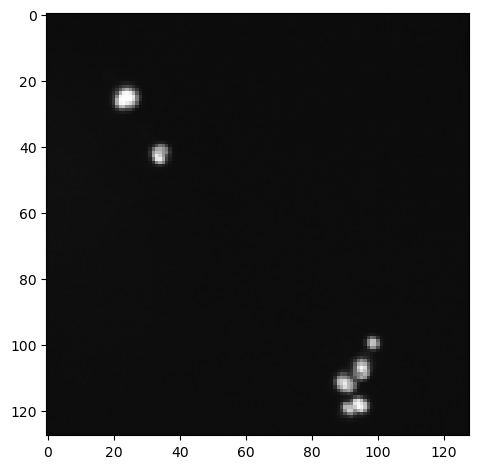

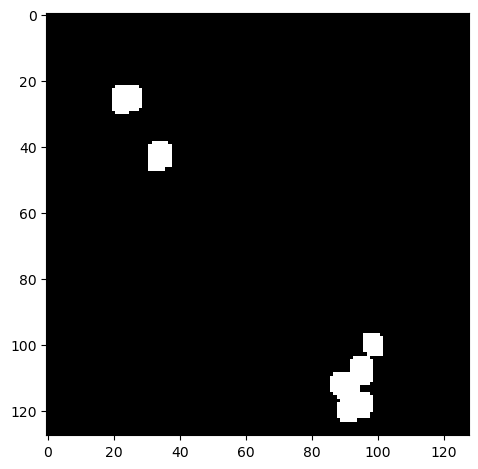

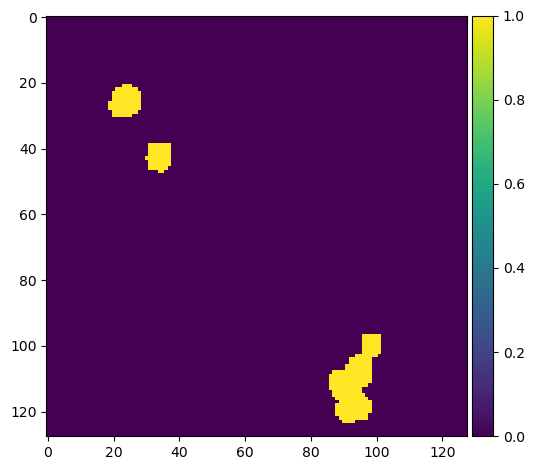

In [8]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
